# DCGAN implemented on MxNet Gluon

In [1]:
from __future__ import print_function
import os
import mxnet as mx
import random
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc

## Initialize the hyper parameters

In [2]:
class Options:
    def __init__(self):
        self.dataset = 'celebA' # cifar10 , celebA
        #self.dataroot = '/EBS100G/GAN_resutls/lfw/lfw-deepfunneled' # path to dataset
        self.dataroot = './data' # path to dataset
        self.batchSize = 64 # input batch size
        self.imageSize = 64 # the height / width of the input image to network'
        self.nz =100 # size of the latent z vector
        self.ngf = 64
        self.ndf = 64 
        self.nc = 3 #numb color
        self.niter =125 # number of epochs to train for
        self.lr = 0.0001 # learning rate, default=0.0002
        self.beta1 = 0.5 # beta1 for adam
        self.beta2 = 0.999 # beta2 for adam
        self.ctx = mx.gpu() #  enables gpu
        self.ngpu = 1 # number of GPUs to use
#         self.G_net = '' # path to netG (to continue training)
#         self.D_net = '' #help="path to netD (to continue training)")
        self.outf = './data' # help='folder to output images and model checkpoints')
        self.manualSeed = random.randint(1, 10000) # manual seed 
        self.clip_gradient = 10.0

opt = Options()
try:
    os.makedirs(opt.outf)
except OSError:
    pass
mx.random.seed(opt.manualSeed)



## Load the target data

In [3]:
def transformer(data, label):
    data = mx.image.imresize(data, opt.imageSize, opt.imageSize)
    data = mx.nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/128.0-1.0 
    return data, label

## Creat a data iterator

In [4]:
if opt.dataset == 'cifar10':
    train_data = gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(opt.dataroot, train=True, transform=transformer),
        batch_size= opt.batchSize, shuffle=True, last_batch='discard')

    test_data = gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(opt.dataroot, train=False, transform=transformer),
        batch_size=opt.batchSize, shuffle=False, last_batch='discard')
    
if opt.dataset == 'celebA':
    opt.dataroot = '%s/celebA/Trainset' % (opt.dataroot)
    train_data = gluon.data.DataLoader(
        gluon.data.vision.ImageFolderDataset(opt.dataroot,transform=transformer),
        batch_size= opt.batchSize, shuffle=True, last_batch='discard')

    test_data = gluon.data.DataLoader(
        gluon.data.vision.ImageFolderDataset(opt.dataroot, transform=transformer),
        batch_size=opt.batchSize, shuffle=False, last_batch='discard')
    


## Creat the Generator and Discriminator networks

In [5]:
G_Net = gluon.nn.Sequential()
with G_Net.name_scope():
    #first layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 8, kernel_size=4,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #second layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 4, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #tird layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf * 2, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #fourth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.ngf, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    #fifth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=opt.nc, kernel_size=4,strides = 2,padding=1,use_bias=False))
    G_Net.add(gluon.nn.Activation('tanh'))

    
    
D_Net = gluon.nn.Sequential()
with D_Net.name_scope():
    #first layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf , kernel_size=4,strides = 2,padding=1, use_bias=False))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #second layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 2, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #tird layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 4, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #fourth layer
    D_Net.add(gluon.nn.Conv2D(channels=opt.ndf * 8, kernel_size=4,strides = 2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    #fifth layer
    D_Net.add(gluon.nn.Conv2D(channels=1, kernel_size=4,strides = 2,padding=0,use_bias=False))
    D_Net.add(gluon.nn.Activation('sigmoid'))
    
g_net = G_Net
d_net = D_Net

## A function to visualizing the created and real images

In [6]:
def image_show(data,padding = 2):
    import math
    datanp = np.clip((data.asnumpy().transpose((0, 2, 3, 1)) + 1.0)*128.0,0,255).astype(np.uint8)
    
    x_dim = min(8, opt.batchSize)
    y_dim = int(math.ceil(float(opt.batchSize) / x_dim))
    height, width = int(opt.imageSize + padding), int(opt.imageSize + padding)
    grid = np.zeros(( height * y_dim + 1 + padding // 2, width * x_dim + 1 + padding // 2,3),dtype = np.uint8)
    k = 0
    for y in range(y_dim):
        for x in range(x_dim):
            if k >= opt.batchSize:
                break
            start_y = y * height + 1 + padding // 2
            end_y = start_y + height - padding 
            start_x = x * width + 1 + padding // 2
            end_x = start_x + width - padding
            np.copyto(grid[start_y:end_y,start_x:end_x,:],datanp[k])
            k = k + 1
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(grid)
    plt.show()
    scipy.misc.imsave('%s/%s/fake_samples_epoch_%03d.png' % (opt.outf,opt.dataset, epoch),grid)
#    plt.savefig('%s/%s/fake_samples_epoch_%03d.png' % (opt.outf,opt.dataset, epoch))
def binary_cross_entropy(yhat, y):
    return - (y * nd.log(yhat)+(1 - y ) * nd.log(1 - yhat))

## Initialize the networks and the optimizers

In [7]:
#Initialization

g_net.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
d_net.collect_params().initialize(mx.init.Normal(0.02), ctx=opt.ctx)
G_trainer = gluon.Trainer(g_net.collect_params(), 'Adam', {'learning_rate': opt.lr * 20,'beta1':opt.beta1,'beta2':opt.beta2,'clip_gradient':opt.clip_gradient})
D_trainer = gluon.Trainer(d_net.collect_params(), 'Adam', {'learning_rate': opt.lr,'beta1':opt.beta1,'beta2':opt.beta2,'clip_gradient':opt.clip_gradient})



## The learning loop

[0/0/125][0/2531] Loss_D: 0.8658 Loss_G: 2.8318 D(x): 0.4954 D(G(z)): 0.4360 / 0.0764


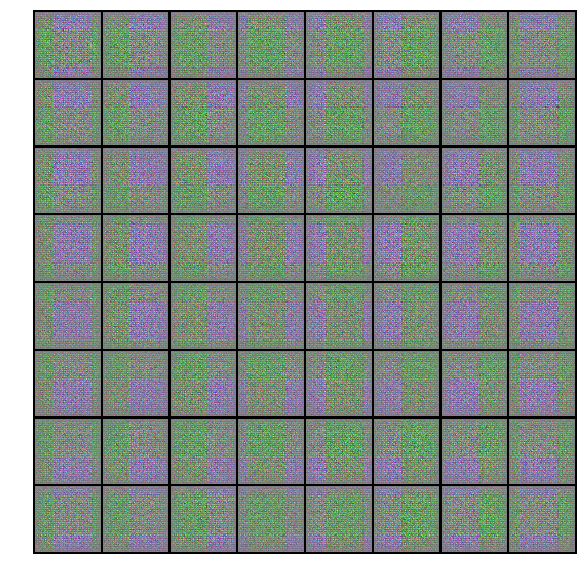

[0/1/125][1/2531] Loss_D: 0.1439 Loss_G: 0.2147 D(x): 0.8838 D(G(z)): 0.9997 / 0.8198
[0/1/125][2/2531] Loss_D: 0.1459 Loss_G: 0.0472 D(x): 0.8904 D(G(z)): 1.0000 / 0.9549
[0/1/125][3/2531] Loss_D: 0.1691 Loss_G: 0.6031 D(x): 0.8816 D(G(z)): 0.9999 / 0.5603
[0/1/125][4/2531] Loss_D: 0.1952 Loss_G: 0.5352 D(x): 0.8491 D(G(z)): 0.9999 / 0.5998
[0/1/125][5/2531] Loss_D: 0.2563 Loss_G: 1.7110 D(x): 0.8449 D(G(z)): 0.9997 / 0.1963
[0/1/125][6/2531] Loss_D: 0.2556 Loss_G: 1.7054 D(x): 0.8171 D(G(z)): 0.9997 / 0.1956
[0/1/125][7/2531] Loss_D: 0.2403 Loss_G: 0.5392 D(x): 0.8188 D(G(z)): 1.0000 / 0.5944
[0/1/125][8/2531] Loss_D: 0.3195 Loss_G: 0.4718 D(x): 0.7801 D(G(z)): 1.0000 / 0.6333
[0/1/125][9/2531] Loss_D: 0.4747 Loss_G: 0.1843 D(x): 0.7155 D(G(z)): 1.0000 / 0.8345
[0/1/125][10/2531] Loss_D: 0.5880 Loss_G: 1.3387 D(x): 0.6689 D(G(z)): 0.9999 / 0.2745
[0/1/125][11/2531] Loss_D: 0.4657 Loss_G: 0.9733 D(x): 0.7332 D(G(z)): 0.9999 / 0.3862
[0/1/125][12/2531] Loss_D: 0.5412 Loss_G: 0.4196 D(x

[0/1/125][96/2531] Loss_D: 2.7681 Loss_G: 4.4773 D(x): 0.3408 D(G(z)): 0.9926 / 0.0122
[0/1/125][97/2531] Loss_D: 2.7365 Loss_G: 4.0017 D(x): 0.3082 D(G(z)): 0.9943 / 0.0194
[0/1/125][98/2531] Loss_D: 2.3286 Loss_G: 3.1666 D(x): 0.3612 D(G(z)): 0.9974 / 0.0441
[0/1/125][99/2531] Loss_D: 2.9874 Loss_G: 3.1909 D(x): 0.2819 D(G(z)): 0.9965 / 0.0431
[0/1/125][100/2531] Loss_D: 2.5619 Loss_G: 3.2139 D(x): 0.2825 D(G(z)): 0.9956 / 0.0416


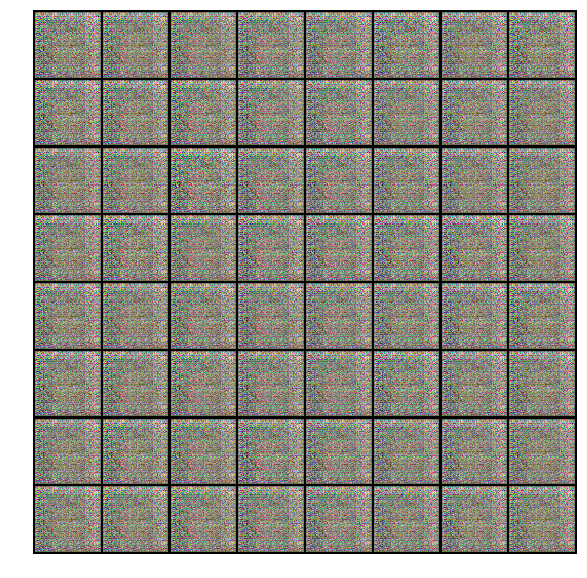

[0/1/125][101/2531] Loss_D: 3.2362 Loss_G: 3.1347 D(x): 0.2325 D(G(z)): 0.9932 / 0.0450
[0/1/125][102/2531] Loss_D: 3.6267 Loss_G: 3.7133 D(x): 0.1799 D(G(z)): 0.9873 / 0.0257
[0/1/125][103/2531] Loss_D: 3.2077 Loss_G: 3.9245 D(x): 0.1967 D(G(z)): 0.9807 / 0.0212
[0/1/125][104/2531] Loss_D: 3.1420 Loss_G: 4.3902 D(x): 0.2347 D(G(z)): 0.9561 / 0.0131
[0/1/125][105/2531] Loss_D: 3.3234 Loss_G: 4.3895 D(x): 0.1793 D(G(z)): 0.9426 / 0.0134
[0/1/125][106/2531] Loss_D: 3.7655 Loss_G: 4.6982 D(x): 0.1541 D(G(z)): 0.8836 / 0.0104
[0/1/125][107/2531] Loss_D: 3.3269 Loss_G: 4.8481 D(x): 0.1951 D(G(z)): 0.8428 / 0.0088
[0/1/125][108/2531] Loss_D: 4.0933 Loss_G: 4.8057 D(x): 0.1641 D(G(z)): 0.7892 / 0.0094
[0/1/125][109/2531] Loss_D: 3.6509 Loss_G: 4.9916 D(x): 0.1654 D(G(z)): 0.7637 / 0.0075
[0/1/125][110/2531] Loss_D: 2.9757 Loss_G: 4.5889 D(x): 0.2681 D(G(z)): 0.8681 / 0.0114
[0/1/125][111/2531] Loss_D: 3.2070 Loss_G: 4.3177 D(x): 0.2586 D(G(z)): 0.9465 / 0.0150
[0/1/125][112/2531] Loss_D: 3.09

KeyboardInterrupt: 

In [8]:
g_net.collect_params().zero_grad()
d_net.collect_params().zero_grad()
counter = 0
for epoch in range(opt.niter):
    for i, (d, _ ) in enumerate(train_data):
        # update D
        data = d.as_in_context(opt.ctx)
        label = nd.ones(opt.batchSize, opt.ctx)
        noise = nd.normal(loc = 0, scale = 1, shape = (opt.batchSize, opt.nz,1,1),ctx = opt.ctx)
        with autograd.record():            
            output = d_net(data)
            D_error = nd.mean(binary_cross_entropy(output,label))
            D_x = nd.mean(output)
            fake_image = g_net(noise)
            output = d_net(fake_image.detach())
            D_error_fake_image = nd.mean(binary_cross_entropy(output,label*0))
            D_G_z1 = nd.mean(output)
            D_e = D_error + D_error_fake_image
            D_e.backward()
        D_trainer.step(opt.batchSize)       
        #update G
        label = nd.ones(opt.batchSize, opt.ctx)
        with autograd.record():
            fake_image = g_net(noise)
            output = d_net(fake_image)
            G_error = nd.mean(binary_cross_entropy(output,label))
            D_G_z2 = nd.mean(output)
            G_error.backward()
        G_trainer.step(opt.batchSize)
        
        
        print('[%d/%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch,counter, opt.niter, i, len(train_data),
                 D_error.asnumpy(), G_error.asnumpy(), D_x.asnumpy(), D_G_z1.asnumpy(), D_G_z2.asnumpy()))
        trunctate = 1
        if i % (100*trunctate) == 0:
            #image_show(data)
            image_show(fake_image)
        if i % (1000*trunctate) == 0: 
            #plt.savefig('%s/%s/fake_samples_epoch_%03d.png' % (opt.outf,opt.dataset, epoch))
            filenameG = '%s/%s/G_Net_epoch_%d_%d' % (opt.outf, opt.dataset, epoch,counter)
            filenameD = '%s/%s/D_Net_epoch_%d_%d' % (opt.outf, opt.dataset, epoch,counter)
            g_net.save_params(filenameG)
            d_net.save_params(filenameD)
            counter = counter + 1
    counter = 0
